In [1]:
import sys
sys.path.append("../../")  # access to local modules

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

2025-04-04 09:09:25.010217: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from MLDemo import DataPulling, TensorFlowExtensions

In [4]:
CSV_PATH: str = "datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv"
SERVICE_DATE: str = "service_date"
DATE: str = "date"
DAY_TYPE: str = "day_type"
NEXT_DAY_TYPE: str = "next_day_type"
BUS: str = "bus"
RAIL: str = "rail"
TOTAL: str = "total"
ORIGIN: str = "2019-01-01"
START_DATE: str = "2019-03-01"
END_DATE: str = "2019-05-31"

TRAIN_START: str = "2016-01"
TRAIN_END: str = "2018-12"
VALID_START: str = "2019-01"
VALID_END: str = "2019-05"
TEST_START: str = "2019-06"
TRAIN_SCALING: float = 1e6
SEQ_LENGTH: int = 56

In [5]:
df: pd.DataFrame = DataPulling.open_csv(DataPulling.RIDERSHIP, parse_dates=[SERVICE_DATE])

In [6]:
# path = Path(CSV_PATH)
# df: pd.DataFrame = pd.read_csv(path, parse_dates=[SERVICE_DATE])
df.columns = [DATE, DAY_TYPE, BUS, RAIL, TOTAL]

df = df.sort_values(DATE).set_index(DATE)
df = df.drop(TOTAL, axis = 1)
df = df.drop_duplicates()
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


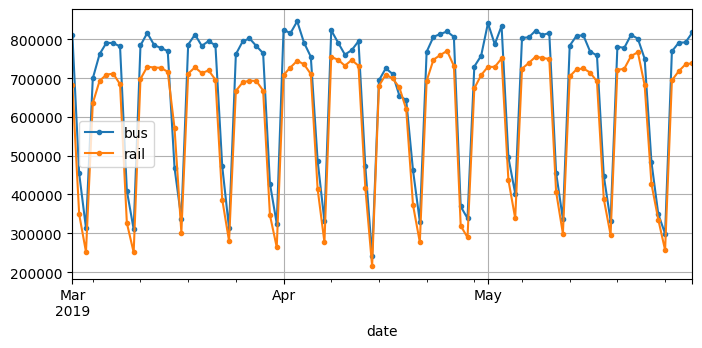

In [7]:
df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.show()

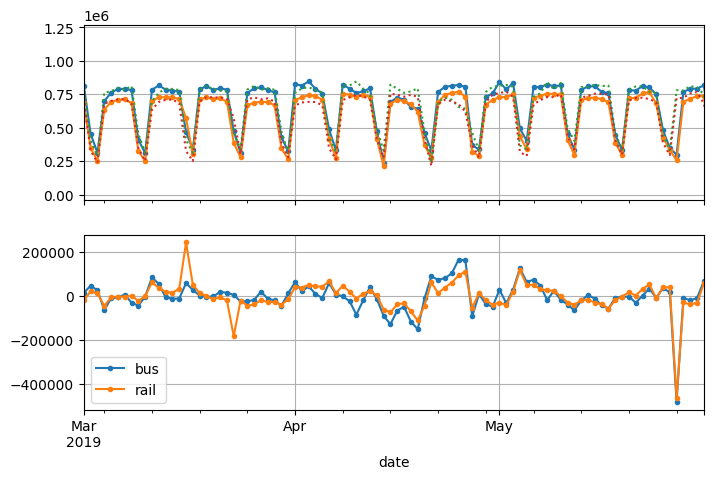

In [8]:
diff_7 = df[[BUS, RAIL]].diff(7)["2019-03":"2019-05"]
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker=".")
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")
diff_7.plot(ax=axs[1], grid=True, marker=".")
plt.show()

In [9]:
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

In [10]:
targets = df[[BUS, RAIL]]["2019-03":"2019-05"]
mape = (diff_7 / targets).abs().mean()
mape

bus     0.082938
rail    0.089948
dtype: float64

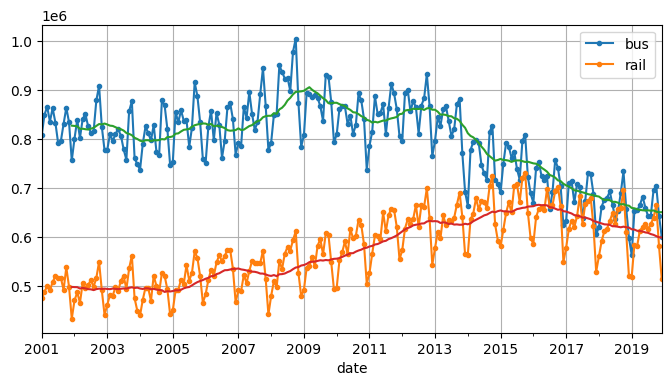

In [11]:
period = slice("2001", "2019")
try:
    df_monthly = df.select_dtypes(include="number").resample('ME').mean()  # compute the mean for each month
    rolling_average_12_months = df_monthly.loc[period].rolling(window=12).mean()
except ValueError as ex:
    try:
        df_monthly = df.select_dtypes(include="number").resample('M').mean()  # compute the mean for each month
        rolling_average_12_months = df_monthly.loc[period].rolling(window=12).mean()
    except ValueError as ex:
        df_monthly = df.resample('M').mean()  # compute the mean for each month
        rolling_average_12_months = df_monthly[period].rolling(window=12).mean()
fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
plt.show()

In [12]:
df_monthly.head()

,bus,rail
date,,
2001-01-31,807190.580645,474591.419355
2001-02-28,848889.000000,488188.178571
2001-03-31,865392.419355,498825.096774
2001-04-30,835126.366667,490444.533333
2001-05-31,862701.419355,507862.258065


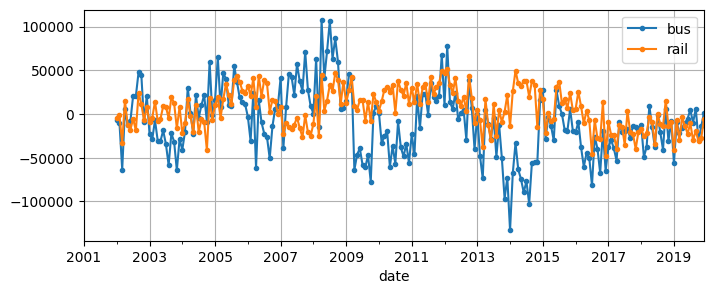

In [13]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8, 3))
plt.show()

## SARIMA - Seasonal Auto Regressive Integrated Moving Average

In [14]:
from statsmodels.tsa.arima.model import ARIMA

In [15]:
from statsmodels.tsa.arima.model import ARIMA

rail_series = df.loc[ORIGIN:END_DATE][RAIL].asfreq("D")
model = ARIMA(rail_series,
              order=(1, 0, 0),
              seasonal_order=(0, 1, 1, 7))
model = model.fit()
y_pred = model.forecast()  # returns 427,758.6
y_pred

2019-06-01    427758.626288
Freq: D, dtype: float64

In [16]:
time_period = pd.date_range(START_DATE, END_DATE)
rail_series = df.loc[ORIGIN:END_DATE][RAIL].asfreq("D")
y_preds = []
for today in time_period.shift(-1):
    model = ARIMA(rail_series[ORIGIN:today], order=(1, 0, 0), seasonal_order=(0, 1, 1, 7))  # <- use grid search here
    model = model.fit()
    y_pred = model.forecast().iloc[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()
mae

32040.72009292839

# Data Preparation

In [17]:
# toy data
my_series = [0, 1, 2, 3, 4, 5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(my_series, targets=my_series[3:], sequence_length=3, batch_size=2)

2025-04-04 09:09:29.355750: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-04 09:09:31.528273: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-04 09:09:31.528352: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-04 09:09:31.528367: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2397] Ignoring visible gpu device (device: 0, name: AMD Radeon Graphics, pci bus id: 0000:65:00.0) with AMDGPU version : gfx1103. The supported AMDGPU versions are gfx900, gfx906, gfx908, gfx90a, gfx940, gfx941, gfx942, gfx1030, gfx1100,

In [18]:
list(my_dataset)

2025-04-04 09:09:31.613332: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]], dtype=int32)>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5], dtype=int32)>)]

In [19]:
for window_dataset in tf.data.Dataset.range(6).window(4, shift=1):
    for element in window_dataset:
        print(f"{element}", end=" ")
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 
4 5 
5 


2025-04-04 09:09:31.626330: W tensorflow/core/framework/dataset.cc:993] Input of Window will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2025-04-04 09:09:31.629377: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-04 09:09:31.633240: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-04 09:09:31.638793: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [20]:
for window_dataset in tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True):
    for element in window_dataset:
        print(f"{element}", end=" ")
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 


In [21]:
dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))  # transorms to tensor
for window_tensor in dataset:
    print(f"{window_tensor}")

[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


In [22]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

In [23]:
dataset = to_windows(tf.data.Dataset.range(6), 4)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))

In [24]:
list(dataset)

[(<tf.Tensor: shape=(3,), dtype=int64, numpy=array([0, 1, 2])>,
  <tf.Tensor: shape=(), dtype=int64, numpy=3>),
 (<tf.Tensor: shape=(3,), dtype=int64, numpy=array([1, 2, 3])>,
  <tf.Tensor: shape=(), dtype=int64, numpy=4>),
 (<tf.Tensor: shape=(3,), dtype=int64, numpy=array([2, 3, 4])>,
  <tf.Tensor: shape=(), dtype=int64, numpy=5>)]

In [25]:
rail_train = df[RAIL][TRAIN_START:TRAIN_END] / TRAIN_SCALING
rail_valid = df[RAIL][VALID_START:VALID_END] / TRAIN_SCALING
rail_test = df[RAIL][TEST_START:] / TRAIN_SCALING

In [26]:
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[SEQ_LENGTH:],
    sequence_length=SEQ_LENGTH,
    batch_size=32,
    shuffle=True,
    seed=42
)

In [27]:
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[SEQ_LENGTH:],
    sequence_length=SEQ_LENGTH,
    batch_size=32
)

In [28]:
def train_test_model(model, train_data, valid_data, learning_rate: float, patience: int = 50, epochs: int = 500):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=patience, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_data, validation_data=valid_data, epochs=epochs, callbacks=[early_stopping_cb])
    _, valid_mae = model.evaluate(valid_data)
    return valid_mae * TRAIN_SCALING

In [29]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Input([SEQ_LENGTH]),
    tf.keras.layers.Dense(1)
])
# early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=50, restore_best_weights=True)
# opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
# model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
# history = model.fit(train_ds, validation_data=valid_ds, epochs=500, callbacks=[early_stopping_cb])
# model.evaluate(valid_ds)[1] * TRAIN_SCALING
train_test_model(model, train_ds, valid_ds, 0.02)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1512 - mae: 0.4469 - val_loss: 0.0115 - val_mae: 0.1184
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0127 - mae: 0.1204 - val_loss: 0.0076 - val_mae: 0.0920
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0100 - mae: 0.0996 - val_loss: 0.0082 - val_mae: 0.0978
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090 - mae: 0.0968 - val_loss: 0.0095 - val_mae: 0.1101
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0086 - mae: 0.0968 - val_loss: 0.0058 - val_mae: 0.0798
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0081 - mae: 0.0930 - val_loss: 0.0059 - val_mae: 0.0801
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070 - mae: 0.0868 - val_loss: 0.0052 - val_mae: 0.0748
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0057 - mae: 0.0752 - val_loss: 0.0054 - val_mae: 0.0755
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.006

37762.99953460693

In [30]:
model = tf.keras.Sequential([
    tf.keras.layers.Input([None, 1]),
    tf.keras.layers.SimpleRNN(1)
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = model.fit(train_ds, validation_data=valid_ds, epochs=500, callbacks=[early_stopping_cb])
model.evaluate(valid_ds)[1] * TRAIN_SCALING

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6983 - mae: 1.1157 - val_loss: 0.0687 - val_mae: 0.3259
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0587 - mae: 0.2901 - val_loss: 0.0444 - val_mae: 0.2389
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0322 - mae: 0.1824 - val_loss: 0.0181 - val_mae: 0.1436
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0191 - mae: 0.1699 - val_loss: 0.0176 - val_mae: 0.1424
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0182 - mae: 0.1626 - val_loss: 0.0173 - val_mae: 0.1387
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0183 - mae: 0.1629 - val_loss: 0.0168 - val_mae: 0.1395
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0170 - mae: 0.1588 - val_loss: 0.0164 - val_mae: 0.1384
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0166 - mae: 0.1574 - val_loss: 0.0160 - val_mae: 0.1378
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.016

102808.95978212357

In [31]:
univar_model = tf.keras.Sequential([
    tf.keras.layers.Input([None, 1]),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

tf.random.set_seed(42)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
univar_model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = univar_model.fit(train_ds, validation_data=valid_ds, epochs=500, callbacks=[early_stopping_cb])
univar_model.evaluate(valid_ds)[1] * TRAIN_SCALING

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0898 - mae: 0.2914 - val_loss: 0.0085 - val_mae: 0.1073
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0080 - mae: 0.1032 - val_loss: 0.0044 - val_mae: 0.0745
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0052 - mae: 0.0756 - val_loss: 0.0037 - val_mae: 0.0635
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0047 - mae: 0.0680 - val_loss: 0.0033 - val_mae: 0.0605
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0040 - mae: 0.0629 - val_loss: 0.0037 - val_mae: 0.0621
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0046 - mae: 0.0642 - val_loss: 0.0033 - val_mae: 0.0599
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0042 - mae: 0.0611 - val_loss: 0.0034 - val_mae: 0.0574
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0041 - mae: 0.0607 - val_loss: 0.0027 - val_mae: 0.0491
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.003

30402.04383432865

In [32]:
deep_model = tf.keras.Sequential([
    tf.keras.layers.Input([None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

tf.random.set_seed(42)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
deep_model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = deep_model.fit(train_ds, validation_data=valid_ds, epochs=500, callbacks=[early_stopping_cb])
deep_model.evaluate(valid_ds)[1] * TRAIN_SCALING

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.3378 - mae: 0.6806 - val_loss: 0.0161 - val_mae: 0.1424
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0208 - mae: 0.1727 - val_loss: 0.0157 - val_mae: 0.1505
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0181 - mae: 0.1680 - val_loss: 0.0212 - val_mae: 0.1232
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0180 - mae: 0.1593 - val_loss: 0.0162 - val_mae: 0.1686
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0186 - mae: 0.1670 - val_loss: 0.0217 - val_mae: 0.1245
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0190 - mae: 0.1609 - val_loss: 0.0176 - val_mae: 0.1274
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0167 - mae: 0.1612 - val_loss: 0.0159 - val_mae: 0.1652
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0191 - mae: 0.1663 - val_loss: 0.0159 - val_mae: 0.1657
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - lo

29944.052919745445

In [33]:
df_mulvar = df[[BUS, RAIL]] / TRAIN_SCALING
df_mulvar[NEXT_DAY_TYPE] = df[DAY_TYPE].shift(-1)
df_mulvar = pd.get_dummies(df_mulvar, dtype=float)
df_mulvar.head()

,bus,rail,next_day_type_A,next_day_type_U,next_day_type_W
date,,,,,
2001-01-01,0.297192,0.126455,0.0,0.0,1.0
2001-01-02,0.780827,0.501952,0.0,0.0,1.0
2001-01-03,0.824923,0.536432,0.0,0.0,1.0
2001-01-04,0.870021,0.550011,0.0,0.0,1.0
2001-01-05,0.890426,0.557917,1.0,0.0,0.0


In [34]:
mulvar_train = df_mulvar[TRAIN_START:TRAIN_END]
mulvar_valid = df_mulvar[VALID_START:VALID_END]
mulvar_test = df_mulvar[TEST_START:]

In [35]:
mulvar_train[RAIL][SEQ_LENGTH:]

date
2016-02-26    0.749991
2016-02-27    0.455421
2016-02-28    0.323758
2016-02-29    0.742972
2016-03-01    0.741922
                ...   
2018-12-27    0.453029
2018-12-28    0.493961
2018-12-29    0.307105
2018-12-30    0.265310
2018-12-31    0.386058
Name: rail, Length: 1040, dtype: float64

In [36]:
train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=mulvar_train[[BUS, RAIL]][SEQ_LENGTH:],
    sequence_length=SEQ_LENGTH,
    batch_size=32,
    shuffle=True,
    seed=42
)

valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid[[BUS, RAIL]][SEQ_LENGTH:],
    sequence_length=SEQ_LENGTH,
    batch_size=32
)

test_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_test.to_numpy(),
    targets=mulvar_test[[BUS, RAIL]][SEQ_LENGTH:],
    sequence_length=SEQ_LENGTH,
    batch_size=32
)

In [37]:
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.Input([None, 5]),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(2)
])
tf.random.set_seed(42)
train_test_model(mulvar_model, train_mulvar_ds, valid_mulvar_ds, 0.02)


Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1991 - mae: 0.4522 - val_loss: 0.0107 - val_mae: 0.1362
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0058 - mae: 0.0843 - val_loss: 0.0023 - val_mae: 0.0554
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0527 - val_loss: 0.0026 - val_mae: 0.0617
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0024 - mae: 0.0500 - val_loss: 0.0013 - val_mae: 0.0381
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0023 - mae: 0.0486 - val_loss: 0.0015 - val_mae: 0.0426
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0022 - mae: 0.0465 - val_loss: 0.0013 - val_mae: 0.0387
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021 - mae: 0.0469 - val_loss: 0.0011 - val_mae: 0.0354
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019 - mae: 0.0451 - val_loss: 0.0011 - val_mae: 0.0361
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.001

25506.244972348213

In [38]:
my_series = tf.data.Dataset.range(7)
list(to_windows(my_series,3))

[<tf.Tensor: shape=(3,), dtype=int64, numpy=array([0, 1, 2])>,
 <tf.Tensor: shape=(3,), dtype=int64, numpy=array([1, 2, 3])>,
 <tf.Tensor: shape=(3,), dtype=int64, numpy=array([2, 3, 4])>,
 <tf.Tensor: shape=(3,), dtype=int64, numpy=array([3, 4, 5])>,
 <tf.Tensor: shape=(3,), dtype=int64, numpy=array([4, 5, 6])>]

In [39]:
list(dataset := to_windows(to_windows(my_series, 3), 4))

2025-04-04 09:12:20.237034: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[<tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5]])>,
 <tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [4, 5, 6]])>]

In [40]:
dataset = dataset.map(lambda S: (S[:,0], S[:, 1:]))
list(dataset)

[(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 1, 2, 3])>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[1, 2],
         [2, 3],
         [3, 4],
         [4, 5]])>),
 (<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 2, 3, 4])>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[2, 3],
         [3, 4],
         [4, 5],
         [5, 6]])>)]

In [41]:
seq2seq_train = TensorFlowExtensions.to_seq2seq_dataset(mulvar_train, shuffle=True, seed=42) 
seq2seq_valid = TensorFlowExtensions.to_seq2seq_dataset(mulvar_valid)
seq2seq_test = TensorFlowExtensions.to_seq2seq_dataset(mulvar_test)

In [42]:
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.Input([None, 5]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.Dense(14)
])

In [43]:
train_test_model(seq2seq_model, seq2seq_train, seq2seq_valid, 0.02, epochs=25)  # reduce epochs for shortening my notebook, this trains all 500 steps 

Epoch 1/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1334 - mae: 0.3924 - val_loss: 0.0326 - val_mae: 0.1961
Epoch 2/25
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0284 - mae: 0.1850

/home/dierck/workspace/python/MLTraining/Notebooks/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0270 - mae: 0.1832 - val_loss: 0.0224 - val_mae: 0.1601
Epoch 3/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0194 - mae: 0.1544 - val_loss: 0.0178 - val_mae: 0.1419
Epoch 4/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0159 - mae: 0.1397 - val_loss: 0.0153 - val_mae: 0.1301
Epoch 5/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0137 - mae: 0.1283 - val_loss: 0.0134 - val_mae: 0.1213
Epoch 6/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0122 - mae: 0.1204 - val_loss: 0.0121 - val_mae: 0.1150
Epoch 7/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0111 - mae: 0.1137 - val_loss: 0.0113 - val_mae: 0.1099
Epoch 8/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0103 - mae: 0.1083 - val_loss: 0.0104 - val_mae: 0.1051
Epoch 9/25
24/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0095 - mae: 0.1039

2025-04-04 09:12:22.545736: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0096 - mae: 0.1040 - val_loss: 0.0097 - val_mae: 0.1016
Epoch 10/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0089 - mae: 0.1000 - val_loss: 0.0092 - val_mae: 0.0986
Epoch 11/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0086 - mae: 0.0977 - val_loss: 0.0089 - val_mae: 0.0961
Epoch 12/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083 - mae: 0.0950 - val_loss: 0.0084 - val_mae: 0.0931
Epoch 13/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0079 - mae: 0.0926 - val_loss: 0.0080 - val_mae: 0.0906
Epoch 14/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0077 - mae: 0.0910 - val_loss: 0.0078 - val_mae: 0.0891
Epoch 15/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0074 - mae: 0.0885 - val_loss: 0.0075 - val_mae: 0.0868
Epoch 16/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0071 - mae: 0.0866 - val_loss: 0.0072 - val_mae: 0.0846
Epoch 17/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069 - mae: 0.0

2025-04-04 09:12:25.831789: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - mae: 0.0743 - val_loss: 0.0056 - val_mae: 0.0718
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0066 - mae: 0.0761


71778.43898534775

In [44]:
# predict 14 days ahead of time
X = mulvar_valid.to_numpy()[np.newaxis, :SEQ_LENGTH]
y_pred_14 = seq2seq_model.predict(X)[0, -1]
y_pred_14

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


array([0.8231713 , 0.83964443, 0.7169069 , 0.74586695, 0.4139725 ,
       0.41926685, 0.67900115, 0.80007   , 0.79799724, 0.70840913,
       0.6644894 , 0.43484282, 0.32912296, 0.6835255 ], dtype=float32)

In [45]:
custom_ln_model = tf.keras.Sequential([
    tf.keras.layers.Input([None, 5]),
    tf.keras.layers.RNN(TensorFlowExtensions.LNSimpleRNNCell(32), return_sequences=True),  # RNN for custom cells only, use layers otherwise
    tf.keras.layers.Dense(14)
])

/home/dierck/workspace/python/MLTraining/Notebooks/lib/python3.12/site-packages/keras/src/layers/layer.py:395: UserWarning: `build()` was called on layer 'ln_simple_rnn_cell', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


## LSTM

In [46]:
model = tf.keras.Sequential([
    tf.keras.layers.Input([None, 5]),
    tf.keras.layers.LSTM(32, return_sequences=True),  # use this over RNN(LSTMCell) for performance
    tf.keras.layers.Dense(14)
])

In [47]:
model_gru = tf.keras.Sequential([
    tf.keras.layers.Input([None, 5]),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.Dense(14)
])

## Downsampling with convolutional layer

In [51]:
conv_rnn_model = tf.keras.Sequential([
    tf.keras.layers.Input([None, 5]),
    tf.keras.layers.Conv1D(32, kernel_size=4, strides=2, activation="relu"),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.Dense(14)
])

longer_train = TensorFlowExtensions.to_seq2seq_dataset(mulvar_train, seq_length=112, shuffle=True, seed=42)
longer_valid = TensorFlowExtensions.to_seq2seq_dataset(mulvar_valid, seq_length=112, shuffle=True, seed=42)
longer_test = TensorFlowExtensions.to_seq2seq_dataset(mulvar_test, seq_length=112, shuffle=True, seed=42)

downsampled_train = longer_train.map(lambda X, Y: (X, Y[:, 3::2]))
downsampled_valid = longer_valid.map(lambda X, Y: (X, Y[:, 3::2]))

train_test_model(conv_rnn_model, downsampled_train, downsampled_valid, 0.02)

Epoch 1/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1437 - mae: 0.4707 - val_loss: 0.0273 - val_mae: 0.1728
Epoch 2/500
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0213 - mae: 0.1612

/home/dierck/workspace/python/MLTraining/Notebooks/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0195 - mae: 0.1568 - val_loss: 0.0190 - val_mae: 0.1572
Epoch 3/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0171 - mae: 0.1577 - val_loss: 0.0184 - val_mae: 0.1537
Epoch 4/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0166 - mae: 0.1565 - val_loss: 0.0181 - val_mae: 0.1517
Epoch 5/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0162 - mae: 0.1542 - val_loss: 0.0177 - val_mae: 0.1503
Epoch 6/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0159 - mae: 0.1528 - val_loss: 0.0174 - val_mae: 0.1485
Epoch 7/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0155 - mae: 0.1512 - val_loss: 0.0171 - val_mae: 0.1468
Epoch 8/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0153 - mae: 0.1493 - val_loss: 0.0168 - val_mae: 0.1455
Epoch 9/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0149 - mae: 0.1477 - val_loss: 0.0165 - val_mae: 0.1440
Epoch 10/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0146 - mae: 0.

2025-04-04 10:07:29.528390: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0072 - mae: 0.0903 - val_loss: 0.0080 - val_mae: 0.0927
Epoch 45/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0071 - mae: 0.0899 - val_loss: 0.0079 - val_mae: 0.0920
Epoch 46/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0070 - mae: 0.0890 - val_loss: 0.0078 - val_mae: 0.0914
Epoch 47/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0071 - mae: 0.0891 - val_loss: 0.0078 - val_mae: 0.0909
Epoch 48/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0069 - mae: 0.0881 - val_loss: 0.0077 - val_mae: 0.0904
Epoch 49/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0068 - mae: 0.0873 - val_loss: 0.0076 - val_mae: 0.0898
Epoch 50/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0068 - mae: 0.0869 - val_loss: 0.0076 - val_mae: 0.0893
Epoch 51/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0068 - mae: 0.0867 - val_loss: 0.0075 - val_mae: 0.0888
Epoch 52/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0067 - 

2025-04-04 10:08:10.120138: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0037 - mae: 0.0555 - val_loss: 0.0044 - val_mae: 0.0565
Epoch 173/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0037 - mae: 0.0549 - val_loss: 0.0044 - val_mae: 0.0562
Epoch 174/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0037 - mae: 0.0548 - val_loss: 0.0043 - val_mae: 0.0559
Epoch 175/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0037 - mae: 0.0548 - val_loss: 0.0043 - val_mae: 0.0560
Epoch 176/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0037 - mae: 0.0550 - val_loss: 0.0043 - val_mae: 0.0560
Epoch 177/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mae: 0.0542 - val_loss: 0.0043 - val_mae: 0.0557
Epoch 178/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mae: 0.0545 - val_loss: 0.0043 - val_mae: 0.0557
Epoch 179/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mae: 0.0543 - val_loss: 0.0043 - val_mae: 0.0555
Epoch 180/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0

2025-04-04 10:09:33.488421: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0459 - val_loss: 0.0038 - val_mae: 0.0507
Epoch 429/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0461 - val_loss: 0.0038 - val_mae: 0.0507
Epoch 430/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0462 - val_loss: 0.0038 - val_mae: 0.0507
Epoch 431/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0460 - val_loss: 0.0038 - val_mae: 0.0507
Epoch 432/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0460 - val_loss: 0.0038 - val_mae: 0.0507
Epoch 433/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mae: 0.0464 - val_loss: 0.0038 - val_mae: 0.0507
Epoch 434/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0461 - val_loss: 0.0038 - val_mae: 0.0507
Epoch 435/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0458 - val_loss: 0.0038 - val_mae: 0.0507
Epoch 436/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0

50587.51255273819

In [ ]:
wavenet_model = tf.keras.Sequential()
wavenet_model.add(tf.keras.layers.Input(shape=None, 5]))
for rate in (1, 2, 4, 8) * 2:
    wavenet_model.add(tf.keras.layers.Conf1D(filters=32, kernel_size=2, padding="causal", activation="relu", dilation_rate=rate))

wavenet_model.add(tf.keras.layers.Conv1D(filters=14, kernel_size=1))